In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae
import time

In [32]:
data_dir = 'ml-1m'

movies_filename = 'movies.dat'
users_filename = 'users.dat'
ratings_filename = 'ratings.dat'

movies_columns = ['MovieID', 'Title', 'Genres']
users_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
ratings_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

def create_dataframe(data_dir, filename, columns):
    data_file = os.path.join(data_dir, filename)
    return pd.read_csv(data_file, delimiter='::', names=columns, encoding='latin-1', engine='python')

movies = create_dataframe(data_dir, movies_filename, movies_columns)
users = create_dataframe(data_dir, users_filename, users_columns)
ratings = create_dataframe(data_dir, ratings_filename, ratings_columns)
data = (users, movies, ratings)

Calculate the average numbers of ratings from each user and to each movie

# Naive Model 4 and 5

In [27]:
len_list_movie = []
len_list_user = []
        
for movie_id in movies['MovieID']:
    len_list_movie.append(len(ratings[ratings['MovieID'] == movie_id]['Rating'] ))
for user_id in users['UserID']:
    len_list_user.append(len(ratings[ratings['UserID'] == user_id]['Rating']))

print('Mean number of ratings for each movie',np.mean(np.array(len_list_movie)))
print('Mean number of ratings from each user',np.mean(np.array(len_list_user)))

Mean number of ratings for each movie 257.5866597991244
Mean number of ratings from each user 165.5975165562914


We only take the average ratings for a certain movie and from a certain user, if that movie is rated by the number of times larger than the counts parameter, or if that user has given the number of ratings larger than the counts parameters. Otherwise, we choose the global mean to be the average ratings for that movie or user. If a movie or user are not appear in the training set, we also use the global mean to represent their average ratings.

In [36]:
def choosing_mean(ratings,global_mean,counts):
            if len(ratings) > counts:
                return ratings.mean()
                
            else:
                return global_mean

The function for calculating the RMSE and MAE errors

In [50]:
def error_4_5(test_set,reg,mean_rating_per_movie,mean_rating_per_user,rounding):
    ##create the input matrix X=[Ritem,Ruser]
    mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in test_set['MovieID']])
    mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in test_set['UserID']])
    
    ##the predicted rating value for the test set using model 4 and 5.
    mean_rating_list = np.vstack((mean_rating_per_user_list,mean_rating_per_movie_list)).T
    pre_rating = reg.predict(mean_rating_list)
    
    ##if rounding is true,round the values bigger than 5 to 5 and smaller than
    ##1 to 1
    if rounding:
        pre_rating[pre_rating>5]=5
        pre_rating[pre_rating<1]=1
    
    ##calculate the rmse and mae of the for the prediction value
    rating_error_rmse = np.sqrt(((test_set['Rating'] - pre_rating)**2).mean())
    rating_error_mae = mae(test_set['Rating'],pre_rating)
    
    
    return rating_error_rmse,rating_error_mae
    
    

In [51]:
def test_naive_model_4_5(data, counts, rounding):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors_4_rmse_train = np.array([])
    rating_errors_5_rmse_train = np.array([])
    rating_errors_4_mae_train = np.array([])
    rating_errors_5_mae_train = np.array([])
    
    rating_errors_4_rmse = np.array([])
    rating_errors_5_rmse = np.array([])
    rating_errors_4_mae = np.array([])
    rating_errors_5_mae = np.array([])
    
    mean = ratings['Rating'].mean()
    
    ##calculate the average Ritems and average Rusers, and store them in two dicts
    mean_rating_per_movie = {movie_id : choosing_mean(ratings[ratings['MovieID'] == movie_id]['Rating'],mean,counts) 
                                 for movie_id in movies['MovieID']}
    mean_rating_per_user =  {user_id : choosing_mean(ratings[ratings['UserID'] == user_id]['Rating'],mean,counts) 
                                 for user_id in users['UserID']}
    
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        
        

        ##the lists of mean Ritem and mean Ruser for each rating in the train_set
        mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in train_set['MovieID']])
        mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in train_set['UserID']])
        
        
        ## stack the Ritem and Ruser lists for linear fitting
        mean_rating_list = np.vstack((mean_rating_per_user_list,mean_rating_per_movie_list)).T
        
        
        
        
        ## uisng Ordinary least squares Linear Regression to find alpha beta and gamma
        reg_4 = LinearRegression(fit_intercept=False).fit(mean_rating_list, train_set['Rating'])
        reg_5 = LinearRegression(fit_intercept=True).fit(mean_rating_list, train_set['Rating'])
        
    
        
        ##RMSE and MAE errors for training set
        rating_err_rmse4_train,rating_err_mae4_train = error_4_5(train_set,reg_4,
                                                                 mean_rating_per_movie,mean_rating_per_user,rounding)
        rating_err_rmse5_train,rating_err_mae5_train = error_4_5(train_set,reg_5,
                                                                 mean_rating_per_movie,mean_rating_per_user,rounding)
        
        ##RMSE and MAE errors for test set
        rating_err_rmse4,rating_err_mae4 = error_4_5(test_set,reg_4,mean_rating_per_movie,mean_rating_per_user,
                                                    rounding)
        rating_err_rmse5,rating_err_mae5 = error_4_5(test_set,reg_5,mean_rating_per_movie,mean_rating_per_user,
                                                    rounding)
        
        rating_errors_4_rmse_train = np.append(rating_errors_4_rmse_train,rating_err_rmse4_train)
        rating_errors_5_rmse_train = np.append(rating_errors_5_rmse_train,rating_err_rmse5_train)
        rating_errors_4_mae_train = np.append(rating_errors_4_mae_train,rating_err_mae4_train)
        rating_errors_5_mae_train = np.append(rating_errors_5_mae_train,rating_err_mae5_train)
        
        rating_errors_4_rmse = np.append(rating_errors_4_rmse,rating_err_rmse4)
        rating_errors_5_rmse = np.append(rating_errors_5_rmse,rating_err_rmse5)
        rating_errors_4_mae = np.append(rating_errors_4_mae,rating_err_mae4)
        rating_errors_5_mae = np.append(rating_errors_5_mae,rating_err_mae5)
        
        
        
        
#         print('Rating Error for Naive Model 4:', rating_err_rmse4,rating_err_mae4)
#         print('Rating Error for Naive Model 5:', rating_err_rmse5,rating_err_mae5)
    print('Train RMSE for Naive Model 4:', np.mean(rating_errors_4_rmse_train))   
    print('Train MAE for Naive Model 4:', np.mean(rating_errors_4_mae_train))
    print('Train RMSE for Naive Model 5:', np.mean(rating_errors_5_rmse_train))   
    print('Train MAE for Naive Model 5:', np.mean(rating_errors_5_mae_train))

    
    print('Test RMSE for Naive Model 4:', np.mean(rating_errors_4_rmse))   
    print('Test MAE for Naive Model 4:', np.mean(rating_errors_4_mae))
    print('Test RMSE for Naive Model 5:', np.mean(rating_errors_5_rmse))   
    print('Test MAE for Naive Model 5:', np.mean(rating_errors_5_mae))
        
        
        

Using global mean as the fall back value 

In [52]:
start = time.time()

test_naive_model_4_5(data,0,True)

end = time.time()

print('Time Required:', end-start)

Train RMSE for Naive Model 4: 0.9473792979101612
Train MAE for Naive Model 4: 0.7592203472550612
Train RMSE for Naive Model 5: 0.9155295183890818
Train MAE for Naive Model 5: 0.7256315303789693
Test RMSE for Naive Model 4: 0.9473790941835633
Test MAE for Naive Model 4: 0.7592229965429839
Test RMSE for Naive Model 5: 0.9155297455136411
Test MAE for Naive Model 5: 0.7256343396338727
Time Required: 28.27229642868042


Using global mean as the fall back value, no rounding

In [29]:
test_naive_model_4_5(data,200,False)

(800167, 2)
[[3.58156445 4.39072464]
 [3.58156445 4.23890533]
 [3.58156445 3.96052632]
 ...
 [3.57771261 3.58156445]
 [3.57771261 3.35614702]
 [3.57771261 3.79916318]]
[4.10045617 4.00222783 3.82211432 ... 3.57556821 3.42972128 3.71635637]
[[3.58156445 4.39072464]
 [3.58156445 4.23890533]
 [3.58156445 3.96052632]
 ...
 [3.57771261 3.58156445]
 [3.57771261 3.35614702]
 [3.57771261 3.79916318]]
[4.33680742 4.19238902 3.9275805  ... 3.56364322 3.34921448 3.7706344 ]
Rating Error for Naive Model 4: 1.0028222348196791 0.8085080988634691
Rating Error for Naive Model 5: 0.9728672766757607 0.7747892149583154
(800167, 2)
[[3.58156445 4.11079545]
 [3.58156445 4.24796275]
 [3.58156445 3.88584906]
 ...
 [3.57771261 4.56050955]
 [3.57771261 4.33735394]
 [3.57771261 3.97674419]]
[3.91849283 4.00714829 3.77310304 ... 4.20780016 4.06356781 3.83049461]
[[3.58156445 4.11079545]
 [3.58156445 4.24796275]
 [3.58156445 3.88584906]
 ...
 [3.57771261 4.56050955]
 [3.57771261 4.33735394]
 [3.57771261 3.9767441

# UV decomposition

In [63]:
def initialUV(d,global_mean,global_std):
    val = np.sqrt(global_mean/d)
    std = np.sqrt(global_std/d)
#     U = np.random.uniform(val-std,val+std,(6040,d))
#     V = np.random.uniform(val-std,val+std,(d,3952))
    U = np.random.uniform(val-std,val+std,(6040,d))
    V = np.random.uniform(val-std,val+std,(d,3952))
    return U,V


def rmse_mae(U,V,M):
    predict = np.matmul(U,V)
    non_nan = np.count_nonzero(~np.isnan(predict-M))
    rmse = np.sqrt(np.nansum((predict-M)**2)/non_nan)
    mae = np.sqrt(np.nansum(np.abs(predict-M))/non_nan)
    
    return rmse,mae


def updateU(U,V,M):
    for r in range (len(U)):
        for s in range ((len(U[0]))):
            ##[SIGMA k!=s u_rk*v_kj,] for all j
            sum_array=np.matmul(U[r,:],V[:])-(U[r,s]*V[s,:])
            ##[m_ij-sum_array,] for all j
            sub = M[r,:]-sum_array
            ## SIGMA j v_sj*(m_ij-sum_array)
            numerator = np.nansum(V[s,:]*sub)
            
            v_array=np.array(V[s,:])
            v_array[np.isnan(M[r,:])]=np.nan
            denominator=np.nansum(np.square(v_array))
            
            U[r,s] = (U[r,s]+(numerator/denominator))/2
            #print('newU',U[r.s])
            
            
def updateV(U,V,M):
    for r in range (len(V)):
        for s in range ((len(V[0]))):
            ##[SIGMA k!=s u_rk*v_kj,] for all j
            sum_array=np.matmul(U[:],V[:,s])-(U[:,r]*V[r,s])
            ##[m_ij-sum_array,] for all j
            sub = M[:,s]-sum_array
            ## SIGMA j v_sj*(m_ij-sum_array)
            numerator = np.nansum(U[:,r]*sub)
            
            u_array=np.array(U[:,r])
            u_array[np.isnan(M[:,s])]=np.nan
            denominator=np.nansum(np.square(u_array))
            
            V[r,s] = (V[r,s]+(numerator/denominator))/2
            #print('newU',U[r.s])
            
            
            
def updateU_per(U,V,M):
    n=np.random.permutation(range(len(U)))
    m=np.random.permutation(range(len(U[0])))
    for r in n:
        for s in m:
            ##[SIGMA k!=s u_rk*v_kj,] for all j
            sum_array=np.matmul(U[r,:],V[:])-(U[r,s]*V[s,:])
            ##[m_ij-sum_array,] for all j
            sub = M[r,:]-sum_array
            ## SIGMA j v_sj*(m_ij-sum_array)
            numerator = np.nansum(V[s,:]*sub)
            
            v_array=np.array(V[s,:])
            v_array[np.isnan(M[r,:])]=np.nan
            denominator=np.nansum(np.square(v_array))
            
            U[r,s] = (U[r,s]+(numerator/denominator))/2
            #print('newU',U[r.s])
            
            
def updateV_per(U,V,M):
    n=np.random.permutation(range(len(V)))
    m=np.random.permutation(range(len(V[0])))
    for r in n:
        for s in m:
            ##[SIGMA k!=s u_rk*v_kj,] for all j
            sum_array=np.matmul(U[:],V[:,s])-(U[:,r]*V[r,s])
            ##[m_ij-sum_array,] for all j
            sub = M[:,s]-sum_array
            ## SIGMA j v_sj*(m_ij-sum_array)
            numerator = np.nansum(U[:,r]*sub)
            
            u_array=np.array(U[:,r])
            u_array[np.isnan(M[:,s])]=np.nan
            denominator=np.nansum(np.square(u_array))
            
            V[r,s] = (V[r,s]+(numerator/denominator))/2
            #print('newU',U[r.s])

In [69]:
def convert2matrices(data):
    users, movies, ratings = data
    d = 10
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    rating_errors = np.array([])
    matrices_train = []
    matrices_test = []


    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]


        ##create a matrix with #row = numbers of user and #column = # movie , and fill it in with np.nan
        rating_matrix_train = np.full((len(users),3952),np.nan)
        rating_matrix_test = np.full((len(users),3952),np.nan)


        for i in range (len(train_set)):
            rating = train_set.iloc[i]
            rating_matrix_train[rating['UserID']-1][rating['MovieID']-1]=rating['Rating']

        for i in range (len(test_set)):
            rating = test_set.iloc[i]
            rating_matrix_test[rating['UserID']-1][rating['MovieID']-1]=rating['Rating']

        matrices_train.append(rating_matrix_train)
        matrices_test.append(rating_matrix_test)
    return matrices_train,matrices_test

def uv_decomposition(epochs,matrices_train,matrices_test,permutation):
    ##calculate the global mean for the initial value in the U,V matrix.
    global_mean = ratings['Rating'].mean()
    global_std = ratings['Rating'].std()

    U,V = initialUV(2,global_mean,global_std)

    ##calculate the number of nonblank values in the training matrix and test matrix
    non_nan_train = np.count_nonzero(~np.isnan(matrices_train[0]))
    non_nan_test = np.count_nonzero(~np.isnan(matrices_test[0]))

    rmse,mae = rmse_mae(U,V,matrices_train[0])
    print('initial_rmse',rmse)
    print('initial_mae',mae)

    rmse,mae = rmse_mae(U,V,matrices_test[0])
    print('initial_rmse_test',rmse)
    print('initial_mae_test',mae)

    rmse_list_train_mean=[]
    mae_list_train_mean=[]
    rmse_list_test_mean=[]
    mae_list_test_mean=[]
    for i in range (epochs):
        for j in range (5):
            rmse_list_train=[]
            mae_list_train=[]
            rmse_list_test=[]
            mae_list_test=[]
            if permutation:
                updateU_per(U,V,matrices_train[j])
                updateV_per(U,V,matrices_train[j])
            
            else:
                updateU(U,V,matrices_train[j])
                updateV(U,V,matrices_train[j])
            rmse,mae = rmse_mae(U,V,matrices_train[j])
            rmse_test,mae_test = rmse_mae(U,V,matrices_test[j])
            rmse_list_train.append(rmse)
            mae_list_train.append(mae)
            rmse_list_test.append(rmse_test)
            mae_list_test.append(mae_test)
        
        rmse_train_mean = np.mean(np.array(rmse_list_train))
        mae_train_mean = np.mean(np.array(mae_list_train))
        rmse_test_mean = np.mean(np.array(rmse_list_test))
        mae_test_mean = np.mean(np.array(mae_list_test))
        
            
        rmse_list_train_mean.append(rmse_train_mean)
        mae_list_train_mean.append(mae_train_mean)
        rmse_list_test_mean.append(rmse_test_mean)
        mae_list_test_mean.append(mae_test_mean)
    
    return rmse_list_train_mean,mae_list_train_mean,rmse_list_test_mean,mae_list_test_mean
    
    
    


In [70]:
matrices_train,matrices_test = convert2matrices(data)

KeyboardInterrupt: 

uv decomposition without permutation

In [90]:
start = time.time()
rmse_train,mae_train,rmse_test,mae_test = uv_decomposition(25,matrices_train,matrices_test,False)
end = time.time()
print('Time Required:', start-end)

initial_rmse 1.6436728445748015
initial_mae 1.1526596167329608
initial_rmse_test 1.6460291650179883
initial_mae_test 1.153388531893504


<ipython-input-63-6bd7b300e14f>:52: RuntimeWarning: invalid value encountered in double_scalars
  V[r,s] = (V[r,s]+(numerator/denominator))/2


In [91]:
start = time.time()
rmse_train_per,mae_train_per,rmse_test_per,mae_test_per = uv_decomposition(25,matrices_train,matrices_test,True)
end = time.time()
print('Time Required:', start-end)

initial_rmse 1.6188608375663363
initial_mae 1.1432674048779068
initial_rmse_test 1.6177146389461243
initial_mae_test 1.142703416334857


<ipython-input-63-6bd7b300e14f>:93: RuntimeWarning: invalid value encountered in double_scalars
  V[r,s] = (V[r,s]+(numerator/denominator))/2


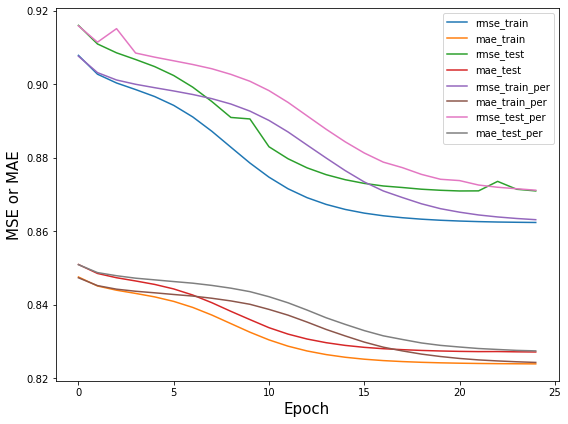

In [96]:
epochs = np.arange(0,25,1)
fig = plt.figure(figsize=(8,6))
plt.plot(epochs,rmse_train,label='rmse_train')
plt.plot(epochs,mae_train,label='mae_train')
plt.plot(epochs,rmse_test,label='rmse_test')
plt.plot(epochs,mae_test,label='mae_test')

plt.plot(epochs,rmse_train_per,label='rmse_train_per')
plt.plot(epochs,mae_train_per,label='mae_train_per')
plt.plot(epochs,rmse_test_per,label='rmse_test_per')
plt.plot(epochs,mae_test_per,label='mae_test_per')

plt.xlabel('Epoch',fontsize=15)
plt.ylabel('MSE or MAE',fontsize=15)

plt.legend()
plt.tight_layout()
fig.savefig('uvdecom.pdf')

